In [6]:
import sys

from tqdm import tqdm

sys.path.append("../")
from calculus_path_mod.term_engine import *
from calculus_path_mod.reduction_strategy import *
from calculus_path_mod.terms import num_comparison, nat_numbers, arithm_ops, combinators, pairs, logic
from calculus_path_mod.terms.pseudonym import *

from calculus_path_mod.json_serialization import load_terms
from fitter import Fitter, get_common_distributions
from calculus_utils.drawing import draw_steps_displot

In [2]:
REDEX_TYPE = {
    "none": "none",
    "norm": "NORM-REDEX",
    "reduce": "REDUCE-REDEX",
    "mult": "MULT-REDEX"
}


class RedexesColoring(OneStepStrategy):
    def _get_redexes_indexes(self, term: Term, init_index: int = 0, path_depth: int = 0) -> dict:
        """
        Using Left Outer strategy find all redexes, it's coordinates in the term tree,
        and the depth value for each redex.

        :param term: some Term is a current vertex
        :param init_index: some index is a coordinate of the current vertex in the term tree
        :param path_depth: depth in the term tree (simply recursion layer).
        :return: dict where a key is a index (coordinate of redex in the term tree),
                 and var is a depth from the tree root
        """

        if (term.kind == "atom") or (len(term.redexes) == 0):
            raise ValueError("The term doesn't contain a redex")
        if term.kind == "application":
            result = dict()
            if term.is_beta_redex:
                result = {**result,
                          **{init_index + 1: path_depth + 1}}
            if len(term._data[0].redexes) != 0:
                result = {**result,
                          **self._get_redexes_indexes(term._data[0], init_index + 1, path_depth + 1)}
            if len(term._data[1].redexes) != 0:
                result = {**result,
                          **self._get_redexes_indexes(term._data[1],
                                                      init_index + term._data[0].vertices_number + 1,
                                                      path_depth + 1)}
            return result
            # self is Abstraction:
        return self._get_redexes_indexes(term._data[1], init_index + 1, path_depth + 1)

    def _get_colored_redexes(self, term: Term) -> dict:
        dict_redexes_indexes = self._get_redexes_indexes(term)
        dict_result = dict()
        for key_, item_ in dict_redexes_indexes.items():
            dict_result[key_] = [item_, REDEX_TYPE["none"]]

        for index_ in dict_result.keys():
            redex_term = term.subterm(index_)

            obj_term = redex_term._data[0]
            subj_term = redex_term._data[1]

            # look at obj-body
            obj_x_var = obj_term._data[0]._data
            obj_body_vars = obj_term._data[1]._vars

            # if obj-body has free x
            if obj_x_var in obj_body_vars.keys():  # check if x in obj_body
                if obj_body_vars[obj_x_var]['free'] == 0:  # x is NOT free in obj_body
                    if len(subj_term.redexes) == 0:
                        dict_result[index_][1] = REDEX_TYPE["norm"]
                    else:
                        dict_result[index_][1] = REDEX_TYPE["reduce"]
                elif obj_body_vars[obj_x_var]['free'] == 1:  # x is free in obj_body
                    if subj_term.kind == "atom":
                        dict_result[index_][1] = REDEX_TYPE["norm"]
                    elif subj_term.kind == "application":
                        dict_result[index_][1] = REDEX_TYPE["norm"]
                    else:  # TODO find out the way to say it more precisely
                        if obj_term._data[1].kind == 'atom':
                            dict_result[index_][1] = REDEX_TYPE["norm"]
                        else:
                            dict_result[index_][1] = REDEX_TYPE["mult"]
                else:  # many x is free in obj_body
                    if subj_term.kind == "atom":
                        dict_result[index_][1] = REDEX_TYPE["norm"]
                    elif subj_term.kind == "application":
                        if len(subj_term.redexes) == 0:
                            dict_result[index_][1] = REDEX_TYPE["norm"]
                        else:
                            dict_result[index_][1] = REDEX_TYPE["mult"]
                    else:  # TODO find out the way to say it more precisely
                        dict_result[index_][1] = REDEX_TYPE["mult"]
            else:  # x is not in obj_body
                if len(subj_term.redexes) == 0:
                    dict_result[index_][1] = REDEX_TYPE["norm"]
                else:
                    dict_result[index_][1] = REDEX_TYPE["reduce"]

            # print("\n\n------------------>")
            # print(f"index {index_}, term: {redex_term.funky_str()}")
            # print(f"obj_term: {obj_term.funky_str()}")
            # print(f"body obj_term vars: {obj_term._data[1]._vars}")
            # print(f"subj_term: {subj_term.funky_str()}")

        return dict_result

    def redex_index(self, term: Term, init_index=0) -> int:
        colored_redexes = self._get_colored_redexes(term)

        if len(colored_redexes) == 0:
            raise Exception("This term doesn't have a Redex")

        # Priority:
        # REDUCE-REDEX > NORM-REDEX > none > MULT-REDEX
        for key, value in colored_redexes.items():
            if value[1] == REDEX_TYPE["reduce"]:
                return key
        for key, value in colored_redexes.items():
            if value[1] == REDEX_TYPE["norm"]:
                return key
        for key, value in colored_redexes.items():
            if value[1] == REDEX_TYPE["none"]:
                return key
        for key, value in colored_redexes.items():
            if value[1] == REDEX_TYPE["mult"]:
                return key

# LOAD TERMS

In [3]:
terms_LO = load_terms("../tests_11_retests/terms_210_filtered_LO.dat")
terms_RI = load_terms("../tests_11_retests/terms_210_filtered_RI.dat")

# TEST ON LO-filtered terms (default generation)

In [4]:
strategy_LO = LOStrategy()
strategy_LI = LIStrategy()
strategy_coloring = RedexesColoring()

steps_coloring_tLO = [term.normalize(strategy_coloring)[1] for term in tqdm(terms_LO, desc="coloring for t-LO")]
steps_LO_tLO = [term.normalize(strategy_LO)[1] for term in tqdm(terms_LO, desc="LO for t-LO")]
steps_LI_tLO = [term.normalize(strategy_LI)[1] for term in tqdm(terms_LO, desc="LI for t-LO")]

LI for t-LO: 100%|██████████| 226/226 [09:20<00:00,  2.48s/it] 


In [7]:
def get_expected_steps(steps):
    steps = list(filter(lambda x: x != float("inf"), steps))
    steps = list(filter(lambda x: x != 0, steps))

    distributions = get_common_distributions()
    distributions.remove("expon")
    f_ln = Fitter([np.log(step) for step in steps], distributions=distributions)
    f_ln.fit()

    mu, sigma = f_ln.fitted_param["norm"]
    result = np.e ** (mu + (sigma ** 2) / 2)
    return result

In [8]:
expected_values = dict()

expected_values["LO-tLO"] = get_expected_steps(steps_LO_tLO)
expected_values["LI-tLO"] = get_expected_steps(steps_LI_tLO)
expected_values["coloring-tLO"] = get_expected_steps(steps_coloring_tLO)

Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 17.96it/s]


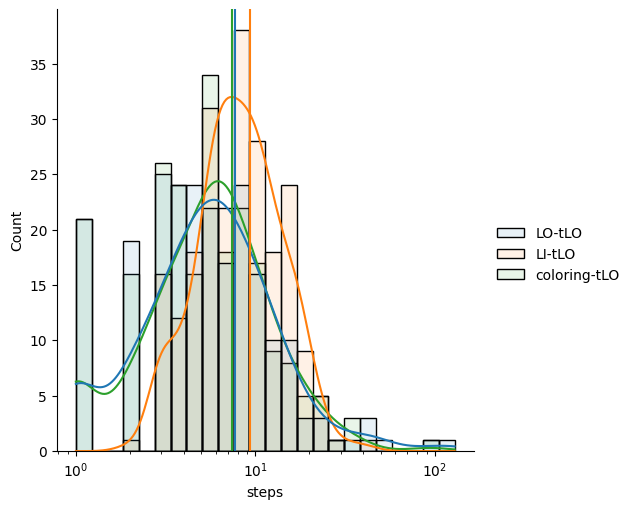

In [9]:
draw_steps_displot(data_to_draw={"LO-tLO": steps_LO_tLO,
                                 "LI-tLO": steps_LI_tLO,
                                 "coloring-tLO": steps_coloring_tLO},
                   y_lines=(expected_values["LO-tLO"], expected_values["LI-tLO"], expected_values["coloring-tLO"]),
                   multiple="layer", element="bars", alpha=0.1)

In [10]:
print(expected_values)

{'LO-tLO': 7.7476494321781155, 'LI-tLO': 9.364138294396199, 'coloring-tLO': 7.397979931934915}


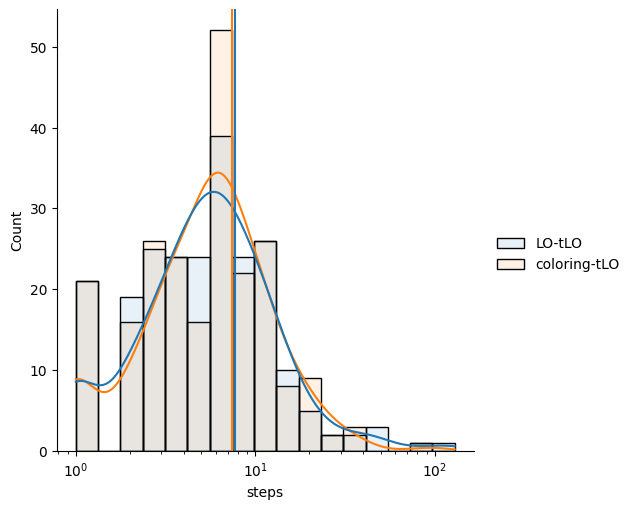

In [11]:
draw_steps_displot(data_to_draw={"LO-tLO": steps_LO_tLO,
                                 "coloring-tLO": steps_coloring_tLO},
                   y_lines=(expected_values["LO-tLO"], expected_values["coloring-tLO"]),
                   multiple="layer", element="bars", alpha=0.1)

# TEST ON RI-filtered terms

In [17]:
from contextlib import contextmanager
import threading
import _thread


class TimeoutException(Exception):
    def __init__(self, msg=''):
        self.msg = msg


@contextmanager
def time_limit(seconds, msg=''):
    timer = threading.Timer(seconds, lambda: _thread.interrupt_main())
    timer.start()
    try:
        yield
    except KeyboardInterrupt:
        raise TimeoutException("Timed out for operation {}".format(msg))
    finally:
        # if the action ends in specified time, timer is canceled
        timer.cancel()


def normalize_term_time_limit(term, strategy):
    result = np.inf
    try:
        with time_limit(60, 'term normalization'):
            result = term.normalize(strategy)[1]
    except TimeoutException:
        pass

    return result

In [18]:
steps_coloring_tRI = [normalize_term_time_limit(term, strategy_coloring) for term in tqdm(terms_RI, desc="coloring for t-RI")]
steps_LO_tRI = [normalize_term_time_limit(term, strategy_LO) for term in tqdm(terms_RI, desc="LO for t-RI")]
steps_LI_tRI = [normalize_term_time_limit(term, strategy_LI) for term in tqdm(terms_RI, desc="LI for t-RI")]




coloring for t-RI:   0%|          | 0/223 [00:00<?, ?it/s]


coloring for t-RI:   3%|▎         | 7/223 [00:00<00:03, 66.48it/s]


coloring for t-RI:   6%|▋         | 14/223 [00:02<00:36,  5.70it/s]


coloring for t-RI:   8%|▊         | 17/223 [00:03<00:43,  4.77it/s]


coloring for t-RI:  13%|█▎        | 29/223 [00:03<00:17, 10.88it/s]


coloring for t-RI:  13%|█▎        | 29/223 [00:21<00:17, 10.88it/s]


coloring for t-RI:  16%|█▌        | 36/223 [01:03<09:07,  2.93s/it]


coloring for t-RI:  18%|█▊        | 40/223 [01:03<07:02,  2.31s/it]


coloring for t-RI:  22%|██▏       | 50/223 [01:03<03:47,  1.31s/it]


coloring for t-RI:  25%|██▍       | 55/223 [01:03<02:49,  1.01s/it]


coloring for t-RI:  27%|██▋       | 60/223 [01:07<02:38,  1.03it/s]


coloring for t-RI:  29%|██▊       | 64/223 [01:08<02:01,  1.31it/s]


coloring for t-RI:  30%|███       | 67/223 [01:08<01:36,  1.61it/s]


coloring for t-RI:  31%|███▏      | 70/223 [01:08<01:19,  1.92it/s]


coloring for t-RI:  33%|███

In [19]:
expected_values["LO-tRI"] = get_expected_steps(steps_LO_tRI)
expected_values["LI-tRI"] = get_expected_steps(steps_LI_tRI)
expected_values["coloring-tRI"] = get_expected_steps(steps_coloring_tRI)




Fitting 9 distributions:   0%|          | 0/9 [00:00<?, ?it/s]SKIPPED powerlaw distribution (taking more than 30 seconds)



Fitting 9 distributions:  33%|███▎      | 3/9 [00:00<00:00, 22.10it/s]


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 22.24it/s]



Fitting 9 distributions:   0%|          | 0/9 [00:00<?, ?it/s]


Fitting 9 distributions:  44%|████▍     | 4/9 [00:00<00:00, 37.37it/s]


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 20.42it/s]



Fitting 9 distributions:   0%|          | 0/9 [00:00<?, ?it/s]SKIPPED powerlaw distribution (taking more than 30 seconds)



Fitting 9 distributions:  22%|██▏       | 2/9 [00:00<00:00, 15.28it/s]


Fitting 9 distributions:  44%|████▍     | 4/9 [00:00<00:00, 15.07it/s]


Fitting 9 distributions:  67%|██████▋   | 6/9 [00:00<00:00, 15.36it/s]


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 16.67it/s]


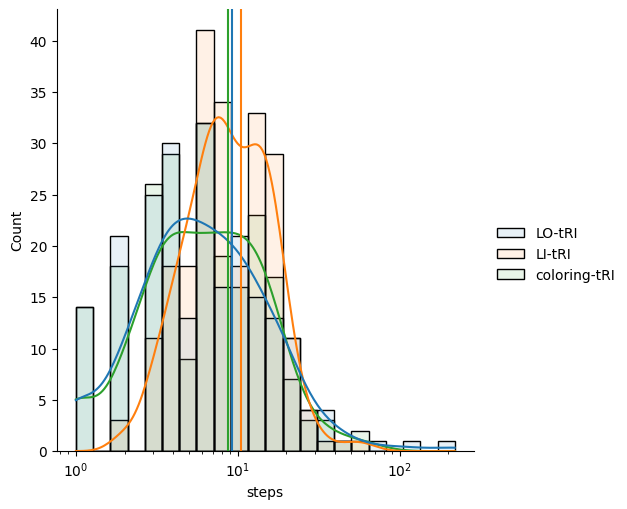

In [20]:
draw_steps_displot(data_to_draw={"LO-tRI": steps_LO_tRI,
                                 "LI-tRI": steps_LI_tRI,
                                 "coloring-tRI": steps_coloring_tRI},
                   y_lines=(expected_values["LO-tRI"], expected_values["LI-tRI"], expected_values["coloring-tRI"]),
                   multiple="layer", element="bars", alpha=0.1)

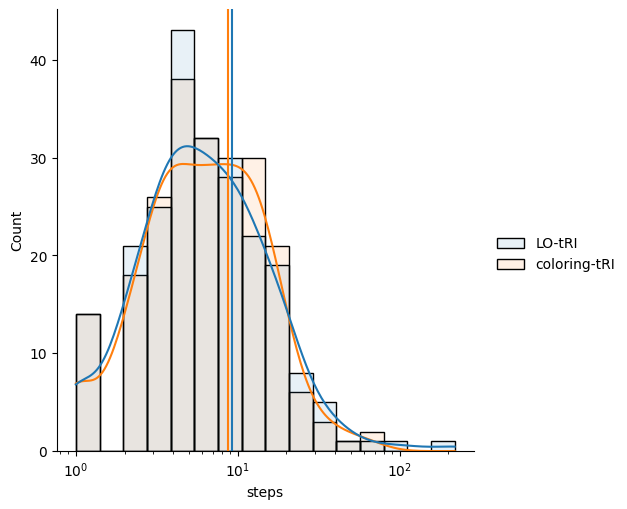

In [21]:
draw_steps_displot(data_to_draw={"LO-tRI": steps_LO_tRI,
                                 "coloring-tRI": steps_coloring_tRI},
                   y_lines=(expected_values["LO-tRI"], expected_values["coloring-tRI"]),
                   multiple="layer", element="bars", alpha=0.1)